In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy import optimize
from scipy import special

from scipy.linalg import lu_factor, lu_solve
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

In [2]:
import discretize
import empymod

## Project package to import

In [3]:
import Project
from Project import EMIP1D
from Project import psuedolog

## IP parameter impact on forwad modelling

In [4]:
t = np.logspace(-8,-2, 121)
tstrt = 1e-4
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]*1e3
print(f"Number of data: {len(tplot)}")

Number of data: 41


In [5]:
res_air = 2e14
res_sea = 1/3
nlayers = 1
btm_fix= True
res_btm = 1
layer_thicknesses = 40
seabed_depth = 1000.1
depth = np.hstack([np.r_[0],seabed_depth+layer_thicknesses * np.arange(nlayers+1)])

Use 1.75 m as distance between receiver and dipole  
3.5m rectangular loop which is inspired by JOGMEC survey  
K.Nakayama(2019)  


In [6]:

model_base = {
    'src':  [1.75,1.75,-1.75,1.75,1000, 1000],
    'rec': [0,0,1000,0,90],
    'depth': depth,
    'freqtime': t ,
    'signal': 0,
    'mrec' : True,
    'verb': 0
}

In [7]:
EMIP =  EMIP1D(IP_model="pelton", model_base=model_base,
    res_air=res_air, res_sea=res_sea, nlayers=nlayers,tindex=tindex,
               btm_fix=btm_fix,res_btm=res_btm)


## Resistivity impact
First we set chargeabillity as zero.

In [8]:
res = 0.2
mvec_r = np.log(res)
mvec_m = 0.0
mvec_t = np.log(1e-3)
mvec_c = 0.5
mvec_ref = np.hstack([mvec_r, mvec_m, mvec_t, mvec_c])
data_ref = EMIP.predicted_data(mvec_ref)
res1 = 10
mvec_r1 = np.hstack([np.log(res1), mvec_m, mvec_t, mvec_c])
data_r1 = EMIP.predicted_data(mvec_r1)
res2 = 1
mvec_r2 = np.hstack([np.log(res2), mvec_m, mvec_t, mvec_c])
data_r2 = EMIP.predicted_data(mvec_r2)
res3 = 0.1 
mvec_r3 = np.hstack([np.log(res3), mvec_m, mvec_t, mvec_c])
data_r3 = EMIP.predicted_data(mvec_r3)

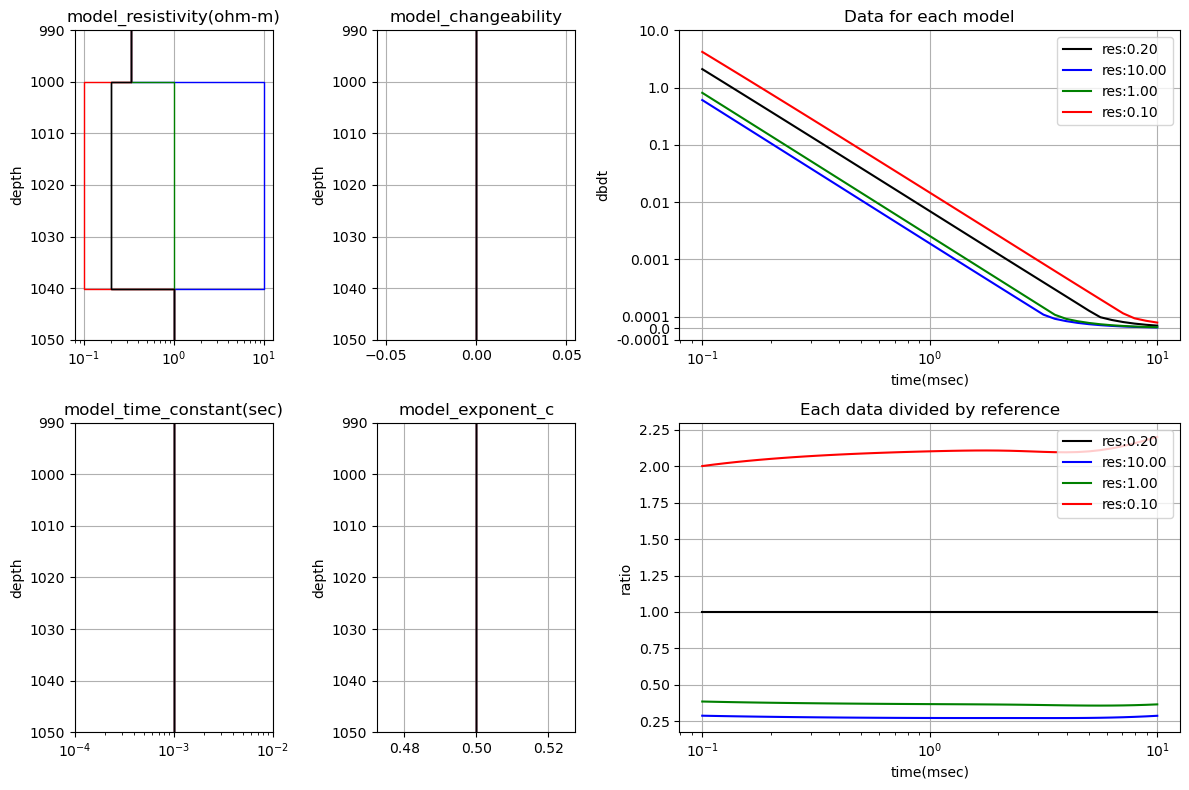

In [9]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 4)  
ax = [None] * 6

ax[0] = fig.add_subplot(gs[0, 0])
ax[1] = fig.add_subplot(gs[0, 1])
ax[2] = fig.add_subplot(gs[1, 0])
ax[3] = fig.add_subplot(gs[1, 1])
ax[4] = fig.add_subplot(gs[0, 2:])
ax[5] = fig.add_subplot(gs[1, 2:])
axip =[ax[0], ax[1], ax[2], ax[3]]
axip = EMIP.plot_IP_par(mvec=mvec_ref,label="reference",      color="k-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_r1, label=f"res:{res1:.2f}",color="b-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_r2, label=f"res:{res2:.2f}",color="g-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_r3, label=f"res:{res3:.2f}",color="r-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_ref,label="reference",      color="k-",ax=axip)

a = 1e-4
b = 0.2
posmax = 10**(np.log10(max(np.r_[a/10, data_ref, data_r1, data_r2, data_r3]) ) // 1 +1)
negmax = 10**(np.log10(max(np.r_[a/10,-data_ref,-data_r1,-data_r2,-data_r3]) ) // 1 +1)
data_plot = psuedolog(posmax=posmax, negmax=negmax, a=a, b=b)
ax[4] = data_plot.pl_plot(tplot, data_ref, ax=ax[4], color="k", label=f"res:{res :.2f}")
ax[4] = data_plot.pl_plot(tplot, data_r1 , ax=ax[4], color="b", label=f"res:{res1:.2f}")
ax[4] = data_plot.pl_plot(tplot, data_r2 , ax=ax[4], color="g", label=f"res:{res2:.2f}")
ax[4] = data_plot.pl_plot(tplot, data_r3 , ax=ax[4], color="r", label=f"res:{res3:.2f}")
ax[4] = data_plot.pl_axes(ax[4])
ax[4].set_title("Data for each model")
ax[4].set_ylabel("dbdt")

# plot ratio
ax[5].semilogx(tplot, data_ref/data_ref, "k", label=f"res:{res:.2f}")
ax[5].semilogx(tplot, data_r1 /data_ref, "b",label=f"res:{res1:.2f}")
ax[5].semilogx(tplot, data_r2 /data_ref, "g",label=f"res:{res2:.2f}")
ax[5].semilogx(tplot, data_r3 /data_ref, "r",label=f"res:{res3:.2f}")
ax[5].set_title("Each data divided by reference")
ax[5].set_ylabel("ratio")
ax[5].grid()

for i in np.arange(4,6):
    ax[i].legend()
    ax[i].set_xlabel("time(msec)")

for i in range(4):  # Iterate over rows
    ax[i].set_ylim([1050, 990])
    ax[i].set_ylabel('depth')
#    ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax[i].grid()
    if i== 0 or i ==2:
        ax[i].set_xscale("log")
    else:
        ax[i].set_xscale("linear")
plt.tight_layout()
plt.savefig("2_IP_impact_pelton_res.png",dpi=300)
plt.show()

## Chargeabillity impact
Change chargeabillity while resistivity fixed as 0.2 ohm.

In [16]:
res = 0.2
mvec_r = np.log(res)
chg = 0.0
mvec_m = chg
tau=1e-3
mvec_t = np.log(tau)
mvec_c = 0.5
mvec_ref = np.hstack([mvec_r, mvec_m, mvec_t, mvec_c])
data_ref = EMIP.predicted_data(mvec_ref)

chg1 = 0.2
mvec_m1 = np.hstack([mvec_r, chg1, mvec_t, mvec_c])
data_m1 = EMIP.predicted_data(mvec_m1)
chg2 = 0.3
mvec_m2 = np.hstack([mvec_r, chg2, mvec_t, mvec_c])
data_m2 = EMIP.predicted_data(mvec_m2)
chg3 = 0.5
mvec_m3 = np.hstack([mvec_r, chg3, mvec_t, mvec_c])
data_m3 = EMIP.predicted_data(mvec_m3)

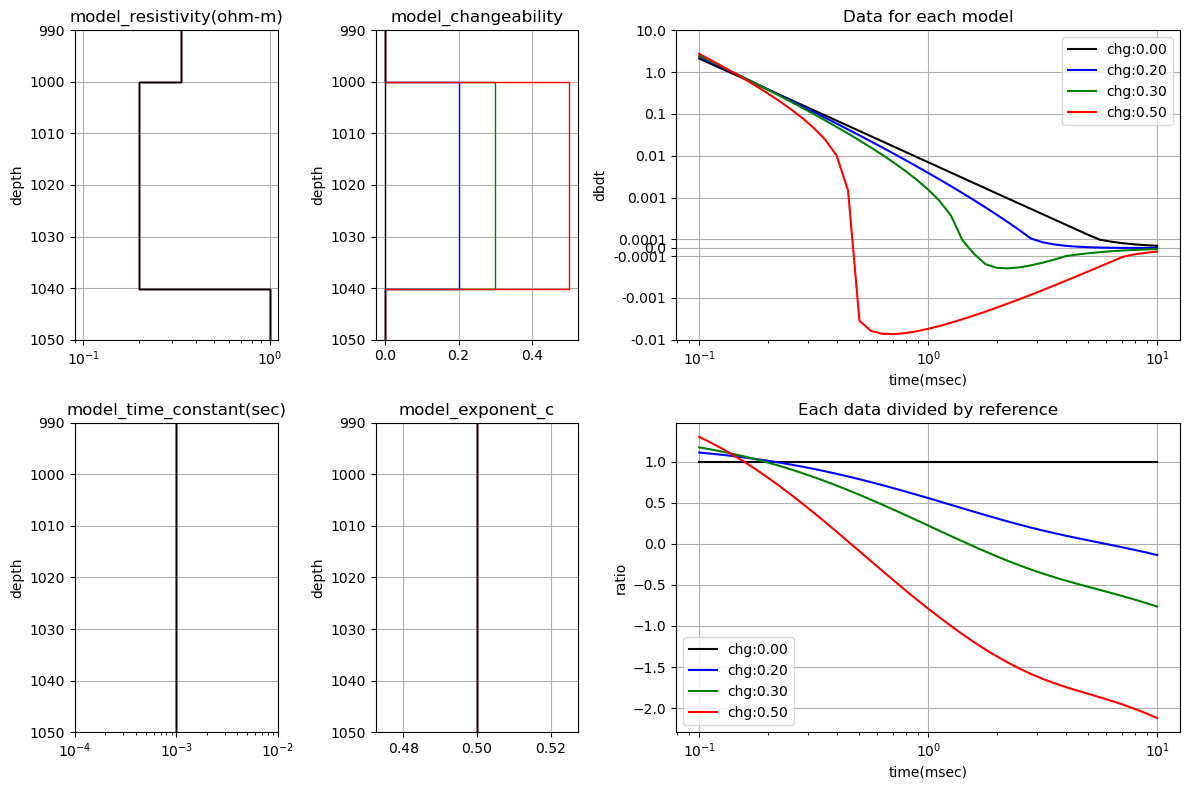

In [17]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 4)  
ax = [None] * 6

ax[0] = fig.add_subplot(gs[0, 0])
ax[1] = fig.add_subplot(gs[0, 1])
ax[2] = fig.add_subplot(gs[1, 0])
ax[3] = fig.add_subplot(gs[1, 1])
ax[4] = fig.add_subplot(gs[0, 2:])
ax[5] = fig.add_subplot(gs[1, 2:])

axip =[ax[0], ax[1], ax[2], ax[3]]
axip = EMIP.plot_IP_par(mvec=mvec_m1, label=f"res:{chg1:.2f}",color="b-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_m2, label=f"res:{chg2:.2f}",color="g-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_m3, label=f"res:{chg3:.2f}",color="r-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_ref,label="reference",      color="k-",ax=axip)

for i in range(4):  # Iterate over rows
    ax[i].set_ylim([1050, 990])
    ax[i].set_ylabel('depth')
#    ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax[i].grid()
    if i== 0 or i ==2:
        ax[i].set_xscale("log")
    else:
        ax[i].set_xscale("linear")
ax[0].set_xlim([0.09,1.1])
a = 1e-4
b = 0.2
posmax = 10**(np.log10(max(np.r_[a/10, data_ref, data_m1, data_m2, data_m3]) ) // 1 +1)
negmax = 10**(np.log10(max(np.r_[a/10,-data_ref,-data_m1,-data_m2,-data_m3]) ) // 1 +1)
data_plot = psuedolog(posmax=posmax, negmax=negmax, a=a, b=b)
ax[4] = data_plot.pl_plot(tplot, data_ref, ax=ax[4], color="k", label=f"chg:{chg :.2f}")
ax[4] = data_plot.pl_plot(tplot, data_m1 , ax=ax[4], color="b", label=f"chg:{chg1:.2f}")
ax[4] = data_plot.pl_plot(tplot, data_m2 , ax=ax[4], color="g", label=f"chg:{chg2:.2f}")
ax[4] = data_plot.pl_plot(tplot, data_m3 , ax=ax[4], color="r", label=f"chg:{chg3:.2f}")
ax[4] = data_plot.pl_axes(ax[4])
ax[4].set_title("Data for each model")
ax[4].set_ylabel("dbdt")

# plot ratio
ax[5].semilogx(tplot, data_ref/data_ref, "k",label=f"chg:{chg:.2f}")
ax[5].semilogx(tplot, data_m1 /data_ref, "b",label=f"chg:{chg1:.2f}")
ax[5].semilogx(tplot, data_m2 /data_ref, "g",label=f"chg:{chg2:.2f}")
ax[5].semilogx(tplot, data_m3 /data_ref, "r",label=f"chg:{chg3:.2f}")
ax[5].set_title("Each data divided by reference")
ax[5].set_ylabel("ratio")
ax[5].grid()

for i in np.arange(4,6):
    ax[i].legend()
    ax[i].set_xlabel("time(msec)")

plt.tight_layout()
plt.savefig("2_IP_impact_pelton_chg.png",dpi=300)
plt.show()

In [12]:
res0 = 0.2
mvec_r = np.log(res0)
chg0 = 0.0
mvec_m = chg
tau=1e-3
mvec_t = np.log(tau)
mvec_c = 0.5
mvec_ref = np.hstack([mvec_r, chg0, mvec_t, mvec_c])
data_ref = EMIP.predicted_data(mvec_ref)

chg= 0.5
tau1 = 1e-4
mvec_t1 = np.hstack([mvec_r, chg , np.log(tau1), mvec_c])
data_t1 = EMIP.predicted_data(mvec_t1)
tau2 = 1e-3 
mvec_t2 = np.hstack([mvec_r, chg , np.log(tau2), mvec_c])
data_t2 = EMIP.predicted_data(mvec_t2)
tau3 = 1e-2
mvec_t3 = np.hstack([mvec_r, chg, np.log(tau3), mvec_c])
data_t3 = EMIP.predicted_data(mvec_t3)

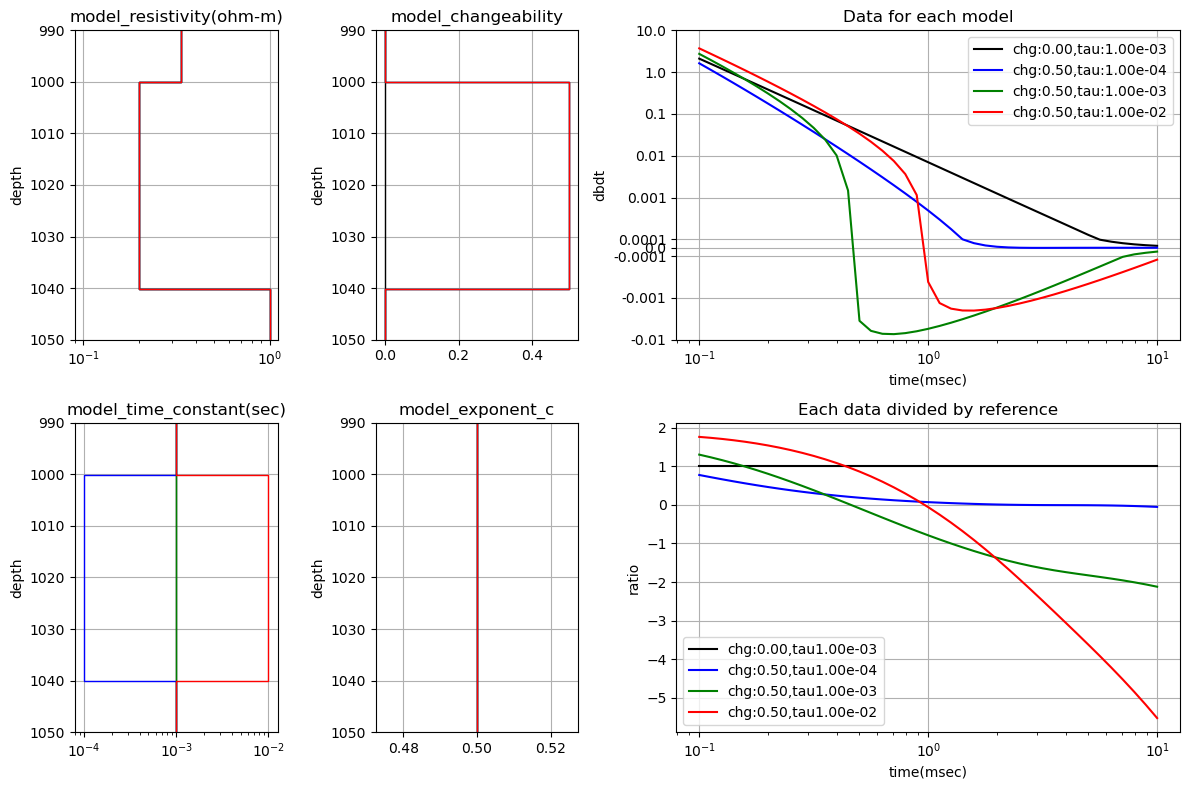

In [13]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 4)  
ax = [None] * 6

ax[0] = fig.add_subplot(gs[0, 0])
ax[1] = fig.add_subplot(gs[0, 1])
ax[2] = fig.add_subplot(gs[1, 0])
ax[3] = fig.add_subplot(gs[1, 1])
ax[4] = fig.add_subplot(gs[0, 2:])
ax[5] = fig.add_subplot(gs[1, 2:])

axip =[ax[0], ax[1], ax[2], ax[3]]
axip = EMIP.plot_IP_par(mvec=mvec_ref,label="reference",      color="k-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_t1, label=f"tau:{tau1:.2e}",color="b-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_t2, label=f"tau:{tau2:.2e}",color="g-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_t3, label=f"tau:{tau3:.2e}",color="r-",ax=axip)

for i in range(4):  # Iterate over rows
    ax[i].set_ylim([1050, 990])
    ax[i].set_ylabel('depth')
#    ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax[i].grid()
    if i== 0 or i ==2:
        ax[i].set_xscale("log")
    else:
        ax[i].set_xscale("linear")
ax[0].set_xlim([0.09,1.1])
a = 1e-4
b = 0.2
posmax = 10**(np.log10(max(np.r_[a/10, data_ref, data_t1, data_t2, data_t3]) ) // 1 +1)
negmax = 10**(np.log10(max(np.r_[a/10,-data_ref,-data_t1,-data_t2,-data_t3]) ) // 1 +1)
data_plot = psuedolog(posmax=posmax, negmax=negmax, a=a, b=b)
ax[4] = data_plot.pl_plot(tplot, data_ref, ax=ax[4], color="k",  label=f"chg:{chg0:.2f},tau:{tau :.2e}")
ax[4] = data_plot.pl_plot(tplot, data_t1 , ax=ax[4], color="b",  label=f"chg:{chg :.2f},tau:{tau1:.2e}")
ax[4] = data_plot.pl_plot(tplot, data_t2 , ax=ax[4], color="g",  label=f"chg:{chg :.2f},tau:{tau2:.2e}")
ax[4] = data_plot.pl_plot(tplot, data_t3 , ax=ax[4], color="r",  label=f"chg:{chg :.2f},tau:{tau3:.2e}")
ax[4] = data_plot.pl_axes(ax[4])
ax[4].set_title("Data for each model")
ax[4].set_ylabel("dbdt")

# plot ratio
ax[5].semilogx(tplot, data_ref/data_ref, "k",label=f"chg:{chg0:.2f},tau{tau:.2e}")
ax[5].semilogx(tplot, data_t1 /data_ref, "b",label=f"chg:{chg :.2f},tau{tau1:.2e}")
ax[5].semilogx(tplot, data_t2 /data_ref, "g",label=f"chg:{chg :.2f},tau{tau2:.2e}")
ax[5].semilogx(tplot, data_t3 /data_ref, "r",label=f"chg:{chg :.2f},tau{tau3:.2e}")
ax[5].set_title("Each data divided by reference")
ax[5].set_ylabel("ratio")
ax[5].grid()

for i in np.arange(4,6):
    ax[i].legend()
    ax[i].set_xlabel("time(msec)")

plt.tight_layout()
plt.savefig("2_IP_impact_pelton_tau.png",dpi=300)
plt.show()

In [14]:
res0 = 0.2
mvec_r = np.log(res)
chg0 = 0.
mvec_m = chg
tau= 1e-3
mvec_t = np.log(tau)
c0 = 0.5
mvec_ref = np.hstack([mvec_r, chg0, mvec_t, c0])
data_ref = EMIP.predicted_data(mvec_ref)

chg = 0.5
c1 = 0.0
mvec_c1 = np.hstack([mvec_r, chg, mvec_t, c1])
data_c1 = EMIP.predicted_data(mvec_c1)
c2 = 0.5 
mvec_c2 = np.hstack([mvec_r, chg, mvec_t, c2])
data_c2 = EMIP.predicted_data(mvec_c2)
c3 = 0.8
mvec_c3 = np.hstack([mvec_r, chg, mvec_t, c3])
data_c3 = EMIP.predicted_data(mvec_c3)

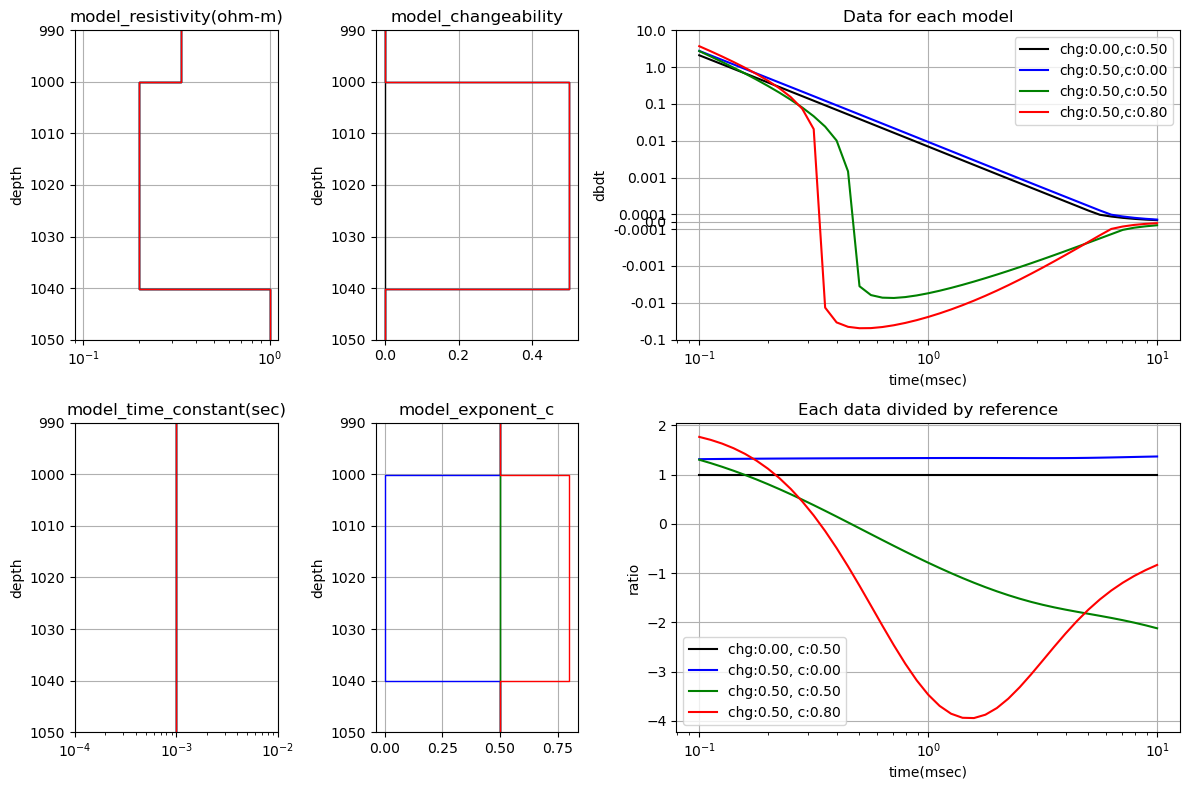

In [15]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 4)  
ax = [None] * 6

ax[0] = fig.add_subplot(gs[0, 0])
ax[1] = fig.add_subplot(gs[0, 1])
ax[2] = fig.add_subplot(gs[1, 0])
ax[3] = fig.add_subplot(gs[1, 1])
ax[4] = fig.add_subplot(gs[0, 2:])
ax[5] = fig.add_subplot(gs[1, 2:])

axip =[ax[0], ax[1], ax[2], ax[3]]
axip = EMIP.plot_IP_par(mvec=mvec_ref,label="reference",   color="k-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_c1, label=f"c:{c1:.2e}" ,color="b-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_c2, label=f"c:{c2:.2e}" ,color="g-",ax=axip)
axip = EMIP.plot_IP_par(mvec=mvec_c3, label=f"c:{c3:.2e}" ,color="r-",ax=axip)

for i in range(4):  # Iterate over rows
    ax[i].set_ylim([1050, 990])
    ax[i].set_ylabel('depth')
#    ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax[i].grid()
    if i== 0 or i ==2:
        ax[i].set_xscale("log")
    else:
        ax[i].set_xscale("linear")
ax[0].set_xlim([0.09,1.1])
    
a = 1e-4
b = 0.2
posmax = 10**(np.log10(max(np.r_[a/10, data_ref, data_c1, data_c2, data_c3]) ) // 1 +1)
negmax = 10**(np.log10(max(np.r_[a/10,-data_ref,-data_c1,-data_c2,-data_c3]) ) // 1 +1)
data_plot = psuedolog(posmax=posmax, negmax=negmax, a=a, b=b)
ax[4] = data_plot.pl_plot(tplot, data_ref, ax=ax[4], color="k",  label=f"chg:{chg0:.2f},c:{c0:.2f}")
ax[4] = data_plot.pl_plot(tplot, data_c1 , ax=ax[4], color="b",  label=f"chg:{chg :.2f},c:{c1:.2f}")
ax[4] = data_plot.pl_plot(tplot, data_c2 , ax=ax[4], color="g",  label=f"chg:{chg :.2f},c:{c2:.2f}")
ax[4] = data_plot.pl_plot(tplot, data_c3 , ax=ax[4], color="r",  label=f"chg:{chg :.2f},c:{c3:.2f}")
ax[4] = data_plot.pl_axes(ax[4])
ax[4].set_title("Data for each model")
ax[4].set_ylabel("dbdt")

# plot ratio
ax[5].semilogx(tplot, data_ref/data_ref, "k",label=f"chg:{chg0:.2f}, c:{c0:.2f}")
ax[5].semilogx(tplot, data_c1 /data_ref, "b",label=f"chg:{chg :.2f}, c:{c1:.2f}")
ax[5].semilogx(tplot, data_c2 /data_ref, "g",label=f"chg:{chg :.2f}, c:{c2:.2f}")
ax[5].semilogx(tplot, data_c3 /data_ref, "r",label=f"chg:{chg :.2f}, c:{c3:.2f}")
ax[5].set_title("Each data divided by reference")
ax[5].set_ylabel("ratio")
ax[5].grid()

for i in np.arange(4,6):
    ax[i].legend()
    ax[i].set_xlabel("time(msec)")

plt.tight_layout()
plt.savefig("2_IP_impact_pelton_c.png",dpi=300)
plt.show()